## Performing HDBSCAN on Iris and Mnist Dataset 


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import hdbscan
from hdbscan.validity import validity_index

import umap
import umap.plot as uplot
from sklearn.datasets import fetch_openml, load_iris
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
from kneed import KneeLocator

sns.set_theme()

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, e

## Getting The Digit dataset


In [2]:
# Load digits data
mnist = fetch_openml('mnist_784', parser='auto')

# Normalize digits data
digits_data = mnist.data/255
digit_labels = mnist.target

# Subset the dataset
digit_labels_df = pd.DataFrame(digit_labels)

label_subset_df = digit_labels_df.groupby('class').head(2000)

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

/var/folders/h2/hlt0n3hj3jx4phv5m7ncq2180000gn/T/ipykernel_12628/116597743.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_subset_df = digit_labels_df.groupby('class').head(2000)


Number of PCA components 784


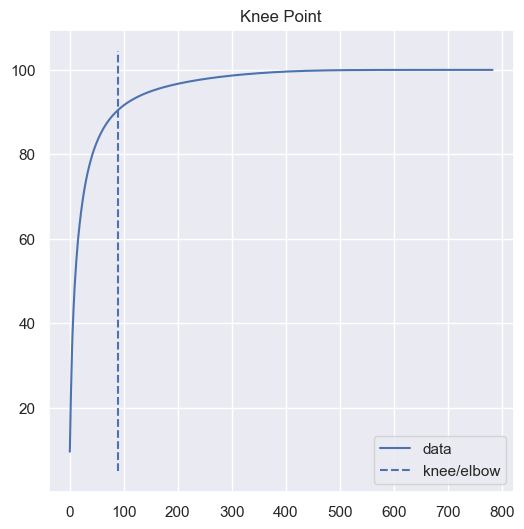

In [3]:
pca = PCA()
pca.fit(digits_data)
pca_transformed_data = pca.transform(digits_data)
print('Number of PCA components {}'.format(pca_transformed_data.shape[1]))
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)), 
    cumulative_explained_variance, 
    S=1.0, 
    curve="concave", 
    direction="increasing"
)
kneedle.plot_knee()

In [4]:
pca_dim_red = pca_transformed_data[:,:50]

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

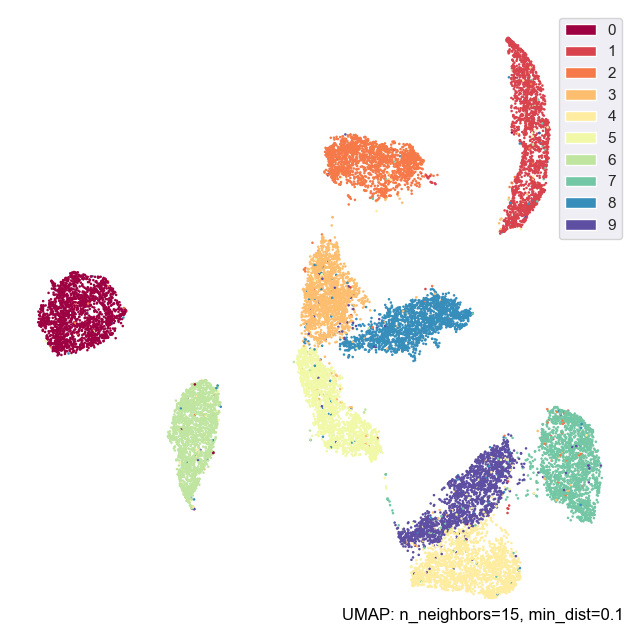

In [5]:
# Default values
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(pca_dim_red)

uplot.points(umap_obj, labels=digit_labels)

In [6]:
def print_clustering_stats(clusterer, clust_data, data_labels):
    
    # Create reduced version of data (exclude noise)
    np_labels = np.array(clusterer.labels_)
    non_noise_idx = np.where(np_labels != -1)

    non_noise_labels = np_labels[non_noise_idx]
    clust_labels_sub = data_labels[non_noise_idx]
    clust_data_sub = clust_data[non_noise_idx]
    noise_size = np_labels.shape[0] - non_noise_labels.shape[0]
    
    print('ARI : {}'.format(adjusted_rand_score(np_labels, data_labels)))
    print('ARI sub : {}'.format(adjusted_rand_score(non_noise_labels, clust_labels_sub)))
    print('noise size : {}'.format(noise_size))
    print('Silouethe : {}'.format(silhouette_score(clust_data, np_labels)))
    print('Silouethe sub : {}'.format(silhouette_score(clust_data_sub, clust_labels_sub)))
    print('DBCV : {}'.format(validity_index(clust_data, np_labels)))
    

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARI : 0.0442132530591348
ARI sub : 0.9975345045483357
noise size : 16973
Silouethe : -0.09945992123941198
Silouethe sub : 0.19471782240622854
DBCV : 0.0331420224774288


<Axes: >

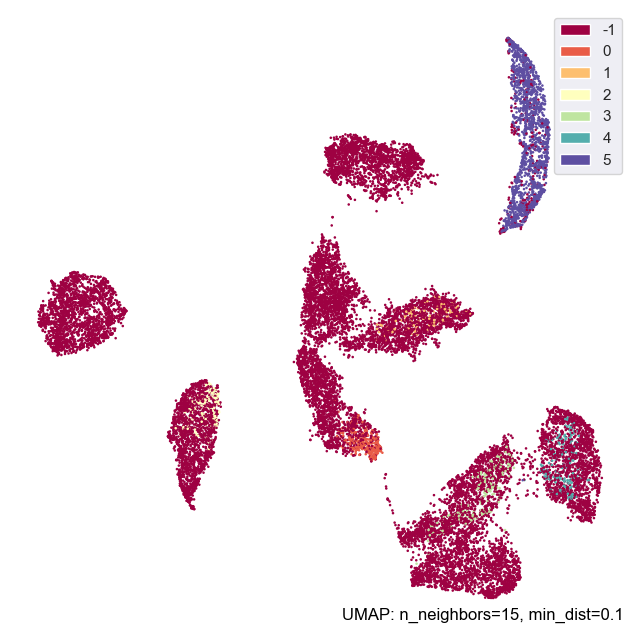

In [7]:
clusterer = hdbscan.HDBSCAN(
    min_samples=5, 
    min_cluster_size=100
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels
)

uplot.points(umap_obj, labels=clusterer.labels_)

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARI : 0.0620451604091957
ARI sub : 0.9949149740514572
noise size : 14873
Silouethe : -0.09463366235628241
Silouethe sub : 0.18540095657238964
DBCV : 0.02754067101276621


<Axes: >

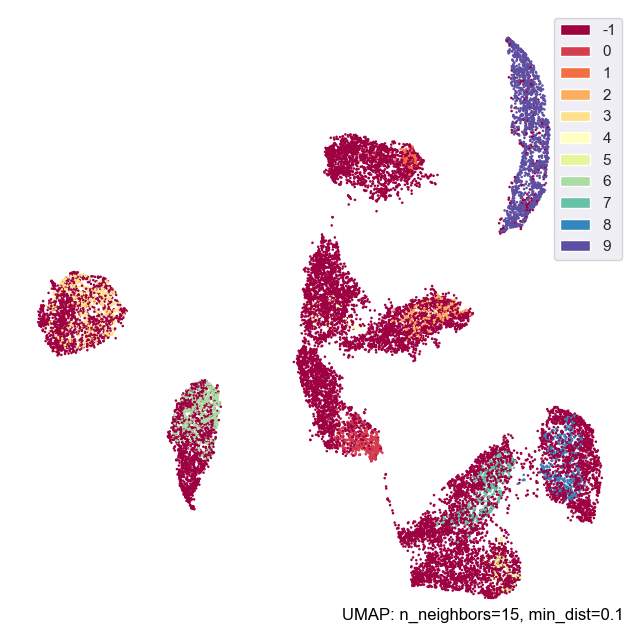

In [8]:
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=100,
    metric='euclidean'
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels
)

uplot.points(umap_obj, labels=clusterer.labels_)

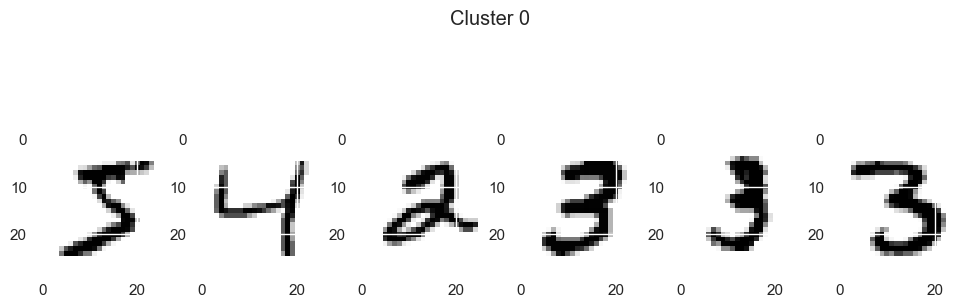

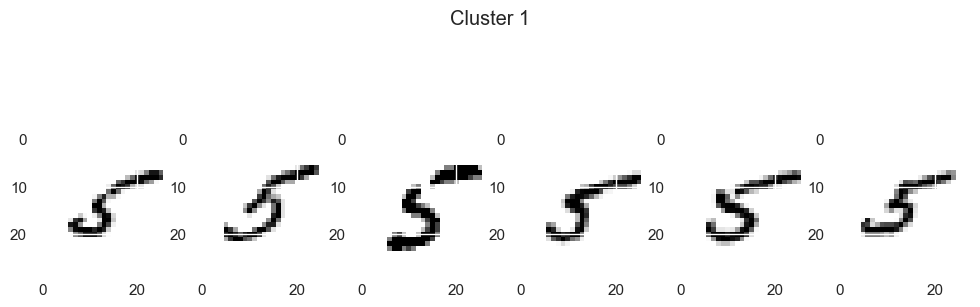

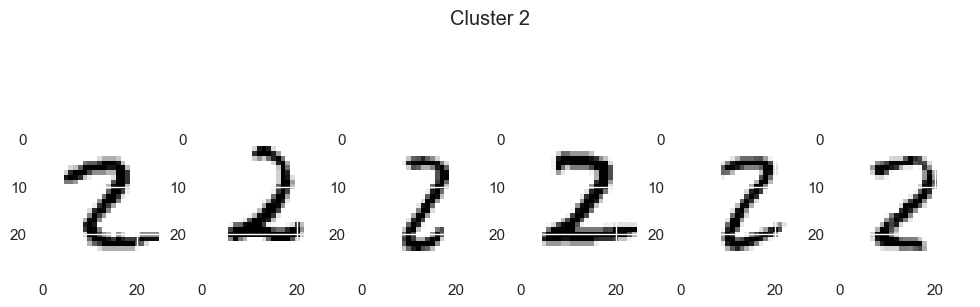

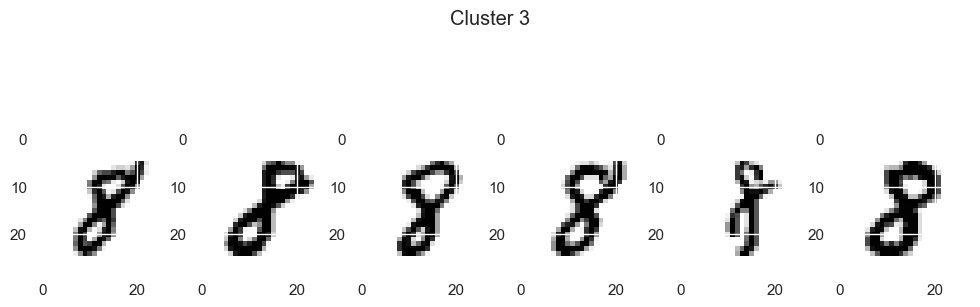

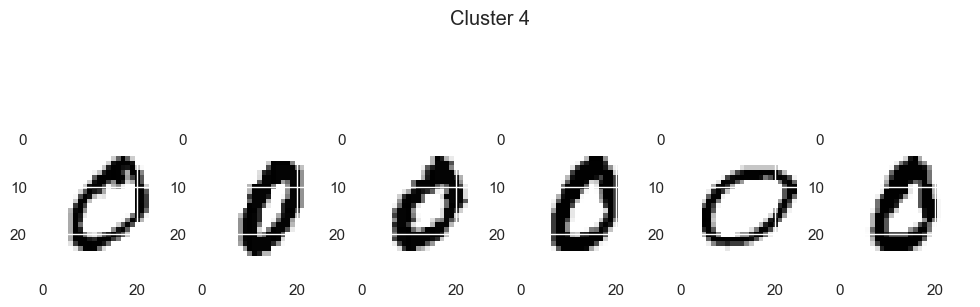

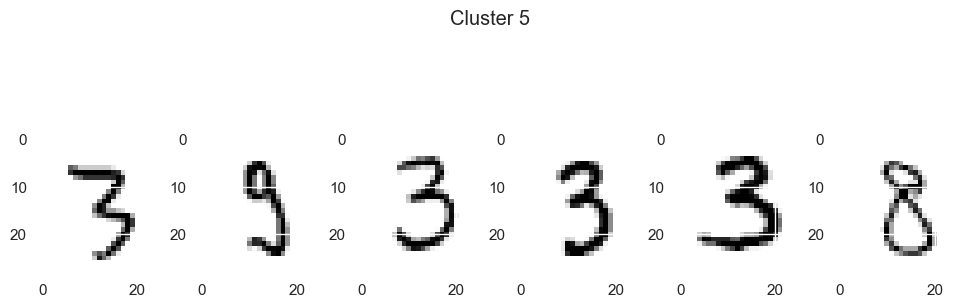

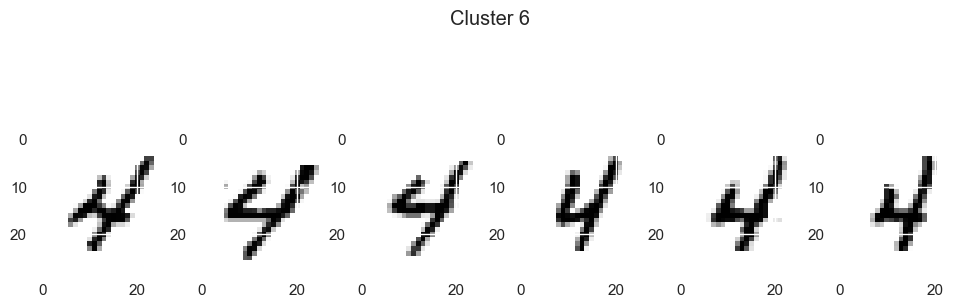

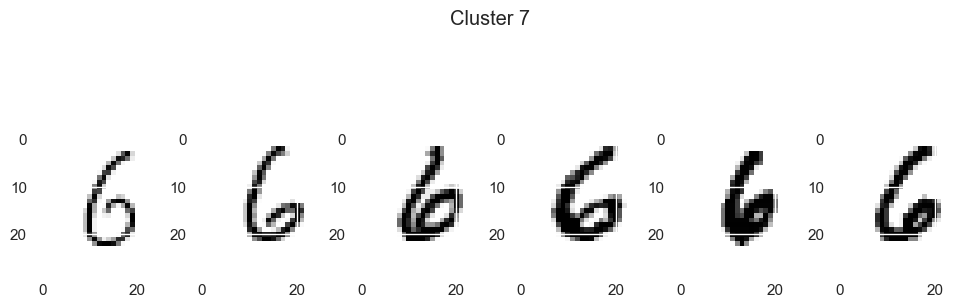

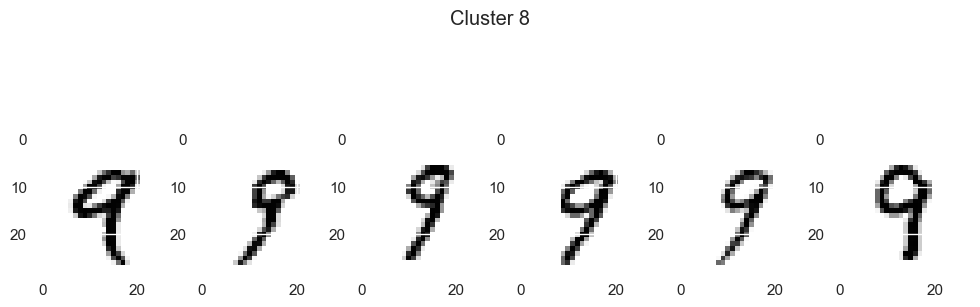

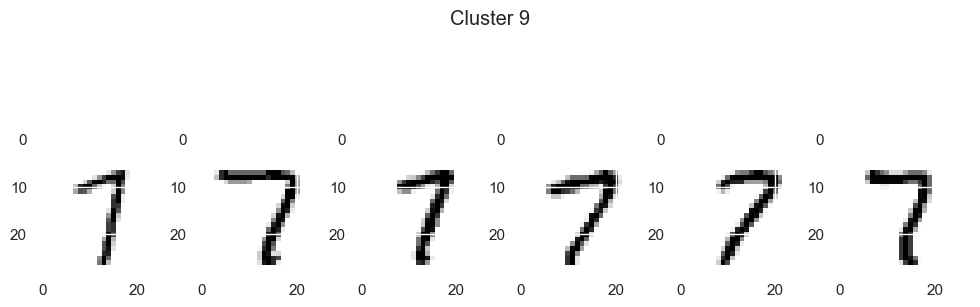

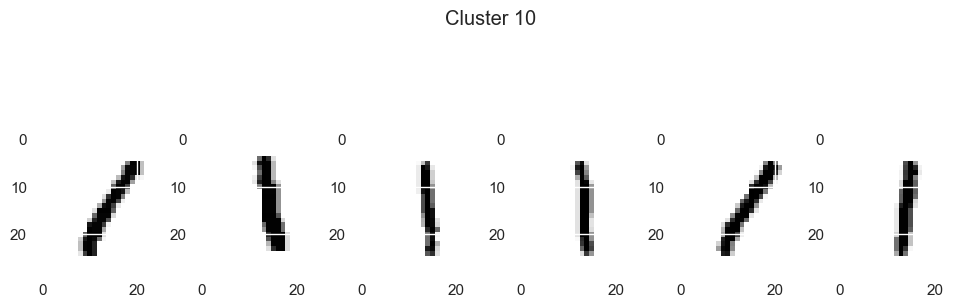

In [9]:
digits_data_rshp = np.reshape(digits_data, newshape=[digits_data.shape[0], 28, 28])

for clust_i, clust_name in enumerate(np.unique(clusterer.labels_)):
    
    clust_samples = np.where(clusterer.labels_==clust_name)[0]
    
    nrows = 1
    ncols = 6
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 4*nrows))  # Adjust the size as needed

    axs = axs.flatten()

    for i, img_idx in enumerate(clust_samples[:6]):
        axs[i].imshow(digits_data_rshp[img_idx], cmap=plt.cm.gray_r)
    fig.suptitle('Cluster {}'.format(clust_i))

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARI : 0.010403832576213518
ARI sub : 0.9363435641342195
noise size : 16930
Silouethe : -0.14687384539336276
Silouethe sub : 0.19974104983261962
DBCV : 0.013114385583956167


<Axes: >

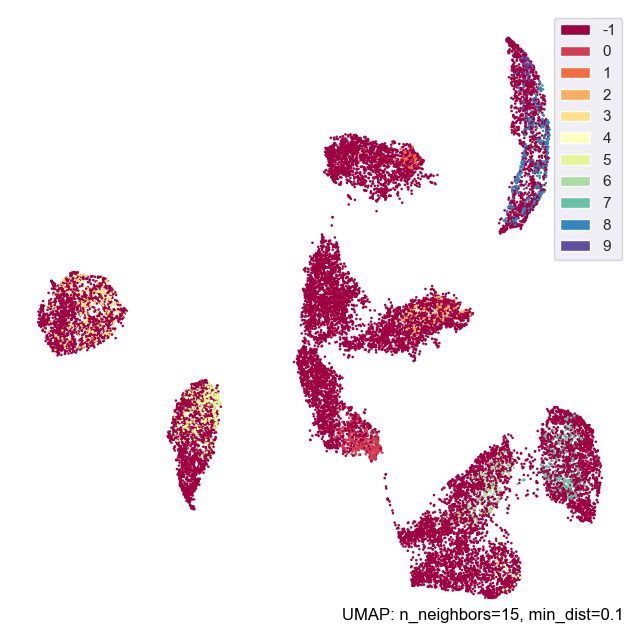

In [10]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=100,
    metric='euclidean',
    cluster_selection_method='leaf'
)
clusterer.fit(pca_dim_red)

print_clustering_stats(
    clusterer=clusterer,
    clust_data=pca_dim_red,
    data_labels=digit_labels
)

uplot.points(umap_obj, labels=clusterer.labels_)

## USing the IRis Dataset 

Text(0.5, 1.0, 'Scatterplot with true label')

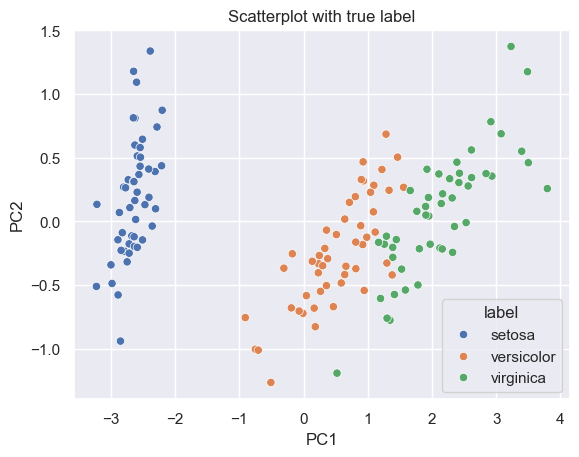

In [11]:
# Load iris dataset
iris = load_iris()

# Load iris dataset
iris_df = pd.DataFrame(
    iris['data'],
    columns=iris['feature_names']
)

numer_cols = iris_df.columns

# Load iris labels
iris_df['label'] = iris['target_names'][iris['target']]

# Run PCA so we can show dataset in 2D space
pca = PCA(n_components=2)
pca_data = pca.fit_transform(iris_df[numer_cols].to_numpy())
pca_data = np.column_stack([pca_data, iris_df['label'].to_numpy()])
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'label'])

# Plot and colour based on reference label
sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label')
plt.title('Scatterplot with true label')

In [12]:
pca_df

,PC1,PC2,label
0,-2.684126,0.319397,setosa
1,-2.714142,-0.177001,setosa
2,-2.888991,-0.144949,setosa
3,-2.745343,-0.318299,setosa
4,-2.728717,0.326755,setosa
...,...,...,...
145,1.94411,0.187532,virginica
146,1.527167,-0.375317,virginica
147,1.764346,0.078859,virginica
148,1.900942,0.116628,virginica


ARI : 0.5681159420289855
ARI sub : 0.5681159420289855
noise size : 0
Silouethe : 0.6867350732769777
Silouethe sub : 0.503477440693296
DBCV : 0.6204492461686151


/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0.5, 1.0, 'Scatterplot with true label')

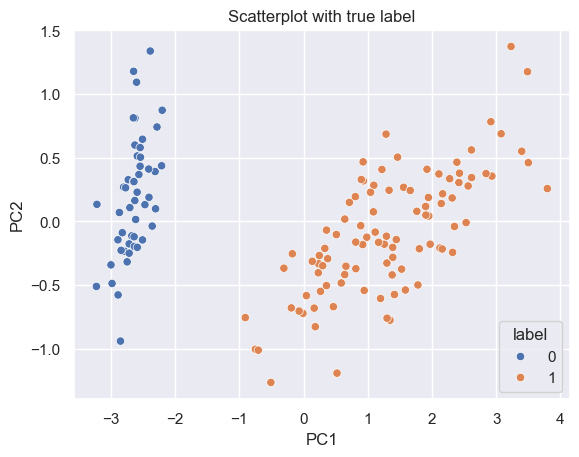

In [13]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2,
    min_cluster_size=20,
    metric='euclidean'
)
clusterer = clusterer.fit(iris_df[numer_cols].to_numpy())

pca_df['label'] = clusterer.labels_

print_clustering_stats(
    clusterer=clusterer,
    clust_data=iris_df[numer_cols].to_numpy(),
    data_labels=iris_df['label'].to_numpy()
)

sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label')
plt.title('Scatterplot with true label')

In [14]:
pca_df

,PC1,PC2,label
0,-2.684126,0.319397,0
1,-2.714142,-0.177001,0
2,-2.888991,-0.144949,0
3,-2.745343,-0.318299,0
4,-2.728717,0.326755,0
...,...,...,...
145,1.94411,0.187532,1
146,1.527167,-0.375317,1
147,1.764346,0.078859,1
148,1.900942,0.116628,1


<Axes: ylabel='distance'>

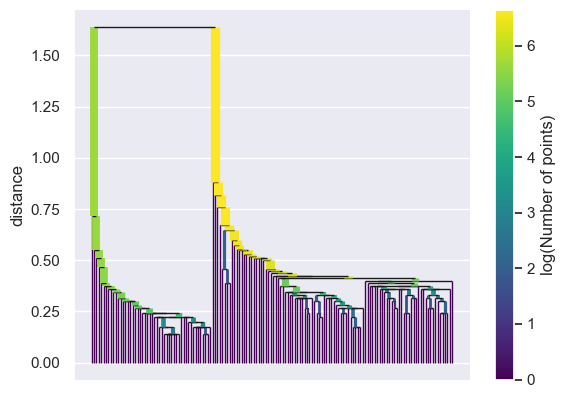

In [15]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

ARI : 0.7426819236947618
ARI sub : 0.9376636738207378
noise size : 23
Silouethe : 0.4017811646609609
Silouethe sub : 0.5440347603184668
DBCV : 0.12879229791577745


/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Text(0.5, 1.0, 'Scatterplot with true label')

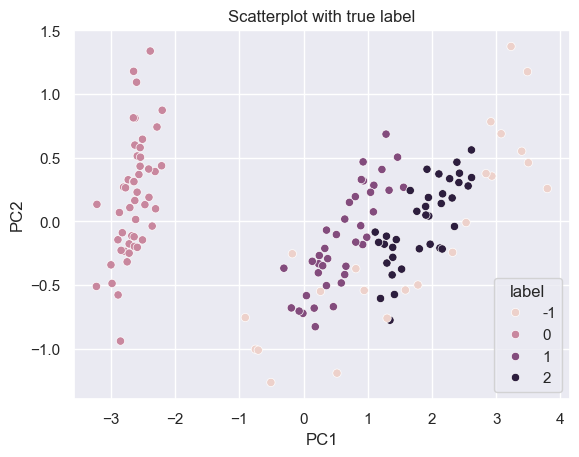

In [16]:
clusterer = hdbscan.HDBSCAN(
    min_samples=1,
    min_cluster_size=30,
    metric='euclidean',
    cluster_selection_method='leaf',
)
clusterer = clusterer.fit(iris_df[numer_cols].to_numpy())

pca_df['label'] = clusterer.labels_

print_clustering_stats(
    clusterer=clusterer,
    clust_data=iris_df[numer_cols].to_numpy(),
    data_labels=iris_df['label'].to_numpy()
)

sns.scatterplot(pca_df, x='PC1', y='PC2', hue='label')
plt.title('Scatterplot with true label')